We want a multiplicative LR for the first alpha epochs which goes from small epsilon to initial_lr.

Then, we want an exponentially decreasing LR that goes from alpha+1 epoch to final epoch

In [1]:
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau


class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [16]:
import matplotlib.pyplot as plt
import torch
import math

model = torch.nn.Sequential(
    torch.nn.Linear(2, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid()    
)

TRAIN_SIZE = 12631
VAL_SIZE = 3158
WARMUP_EPOCHS=30
EPOCHS = 100
BATCH_SIZE = 32
NUM_GPUS = 4

MAX_LR = 0.001

num_train_batches = math.floor(TRAIN_SIZE / BATCH_SIZE / NUM_GPUS)
print(num_train_batches)
num_val_batches = math.ceil(VAL_SIZE / BATCH_SIZE / NUM_GPUS)
print(num_val_batches)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, 
    epochs=EPOCHS,
    steps_per_epoch=num_train_batches,
    pct_start=WARMUP_EPOCHS/EPOCHS
)



# scheduler = GradualWarmupScheduler(optimizer, 1, WARMUP_EPOCHS, scheduler1)

98
25


In [17]:
lrs =[]

for i in range(EPOCHS):
    for i in range(num_train_batches):
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
    #     loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()

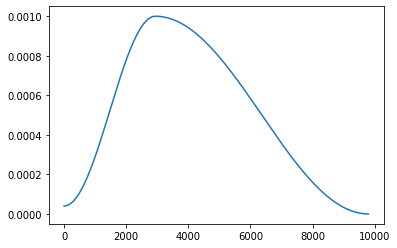

In [18]:
plt.plot(lrs)

In [21]:
lrs[30*num_train_batches]

0.0009999999475688024